In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd

da = pd.read_csv("data_for_lda.csv")


high_rating = da[da['stars_y'] >= 3.5] 
low_rating = da[da['stars_y'] <= 2]   

def create_dtm(dataframe):
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(dataframe['tokens'])
    return dtm, vectorizer


def train_lda(dtm, n_topics=3):
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(dtm)
    return lda

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

high_dtm, high_vectorizer = create_dtm(high_rating)
high_lda = train_lda(high_dtm, n_topics=3) 
print("High-rate topics:")
print_top_words(high_lda, high_vectorizer.get_feature_names(), n_top_words=10) 


low_dtm, low_vectorizer = create_dtm(low_rating)
low_lda = train_lda(low_dtm, n_topics=3)  
print("Low-rate topics:")
print_top_words(low_lda, low_vectorizer.get_feature_names(), n_top_words=10)

High-rate topics:
Topic #0: tacos taco good nt chicken salsa chips ordered like sauce
Topic #1: food place great mexican tacos good service best nt love
Topic #2: food nt service time good place great order table came

Low-rate topics:
Topic #0: chipotle food location nt staff time service love fresh lot
Topic #1: chipotle nt order time food location line people like minutes
Topic #2: chipotle burrito rice good food service bowl like nt order



In [2]:
high_perplexity = high_lda.perplexity(high_dtm)
print("High-rate perplexity:", high_perplexity)


low_perplexity = low_lda.perplexity(low_dtm)
print("Low-rate perplexity:", low_perplexity)


High-rate perplexity: 1435.7247628933544
Low-rate perplexity: 825.0694902862909


In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

da['compound'] = [analyzer.polarity_scores(text)['compound'] for text in da['cleaned_text']]

high_topic_results = high_lda.transform(high_dtm)  
low_topic_results = low_lda.transform(low_dtm)   


high_rate = da[da['stars_y'] >= 3.5].copy()  
low_rate = da[da['stars_y'] <= 2].copy() 

high_rate['high_topic'] = high_lda.transform(high_dtm).argmax(axis=1)
low_rate['low_topic'] = low_lda.transform(low_dtm).argmax(axis=1)

da.loc[high_rate.index, 'high_topic'] = high_rate['high_topic']
da.loc[low_rate.index, 'low_topic'] = low_rate['low_topic']

high_topic_sentiment = da.loc[da['stars_y'] >= 4].groupby('high_topic')['compound'].mean()
low_topic_sentiment = da.loc[da['stars_y'] <= 3].groupby('low_topic')['compound'].mean()

print("sentiment score for high rate:\n", high_topic_sentiment)
print("sentiment score for low rate:\n", low_topic_sentiment)


sentiment score for high rate:
 high_topic
0.0    0.804883
1.0    0.847225
2.0    0.560056
Name: compound, dtype: float64
sentiment score for low rate:
 low_topic
0.0    0.301025
1.0   -0.216969
2.0    0.219409
Name: compound, dtype: float64


In [3]:
high_rate_sentiment_df = da[da['stars_y'] >= 4][['high_topic', 'compound']].copy()
high_rate_sentiment_df['average_sentiment'] = high_rate_sentiment_df.groupby('high_topic')['compound'].transform('mean')

low_rate_sentiment_df = da[da['stars_y'] <= 3][['low_topic', 'compound']].copy()
low_rate_sentiment_df['average_sentiment'] = low_rate_sentiment_df.groupby('low_topic')['compound'].transform('mean')

high_rate_sentiment_df.to_csv('high_rate_sentiment.csv', index=False)
low_rate_sentiment_df.to_csv('low_rate_sentiment.csv', index=False)


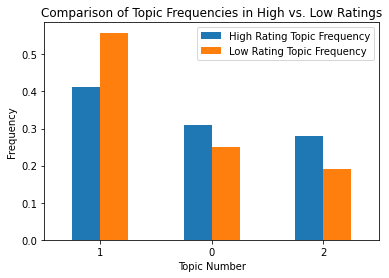

In [8]:
high_topic_freq = high_rate['high_topic'].value_counts(normalize=True)  
low_topic_freq = low_rate['low_topic'].value_counts(normalize=True)
topic_freq_df = pd.DataFrame({'High Rating Topic Frequency': high_topic_freq,
                              'Low Rating Topic Frequency': low_topic_freq}).reset_index()

import matplotlib.pyplot as plt

topic_freq_df.plot(x='index', y=['High Rating Topic Frequency', 'Low Rating Topic Frequency'], kind='bar')
plt.title('Comparison of Topic Frequencies in High vs. Low Ratings')
plt.xlabel('Topic Number')
plt.ylabel('Frequency')
plt.xticks(rotation=0) 
plt.show()


Topic 0: High-rating mean sentiment = 0.7854483397463285, Low-rating mean sentiment = 0.30102523364485995
t-statistic: 12.612163177511372, p-value: 4.389713939864688e-36
Topic 1: High-rating mean sentiment = 0.836186490265678, Low-rating mean sentiment = -0.21696945606694557
t-statistic: 55.953800714457785, p-value: 0.0
Topic 2: High-rating mean sentiment = 0.5208914145414215, Low-rating mean sentiment = 0.21940853658536588
t-statistic: 4.321413787335952, p-value: 1.5738231639254992e-05


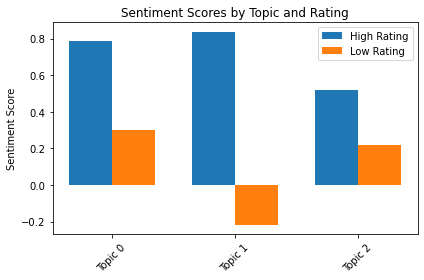

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

cross_topics = set(high_rate['high_topic']) & set(low_rate['low_topic'])

high_topic_sentiment = da.loc[da['high_topic'].isin(cross_topics)].groupby('high_topic')['compound'].mean()
low_topic_sentiment = da.loc[da['low_topic'].isin(cross_topics)].groupby('low_topic')['compound'].mean()

for topic in cross_topics:
    high_mean = high_topic_sentiment[topic]
    low_mean = low_topic_sentiment[topic]
    print(f"Topic {topic}: High-rating mean sentiment = {high_mean}, Low-rating mean sentiment = {low_mean}")

    high_sentiments = da.loc[da['high_topic'] == topic, 'compound']
    low_sentiments = da.loc[da['low_topic'] == topic, 'compound']
    t_stat, p_value = ttest_ind(high_sentiments, low_sentiments)
    print(f"t-statistic: {t_stat}, p-value: {p_value}")

topic_labels = [f"Topic {topic}" for topic in cross_topics]
high_means = [high_topic_sentiment[topic] for topic in cross_topics]
low_means = [low_topic_sentiment[topic] for topic in cross_topics]

x = np.arange(len(cross_topics))  
width = 0.35  

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, high_means, width, label='High Rating')
rects2 = ax.bar(x + width/2, low_means, width, label='Low Rating')

ax.set_ylabel('Sentiment Score')
ax.set_title('Sentiment Scores by Topic and Rating')
ax.set_xticks(x)
ax.set_xticklabels(topic_labels)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


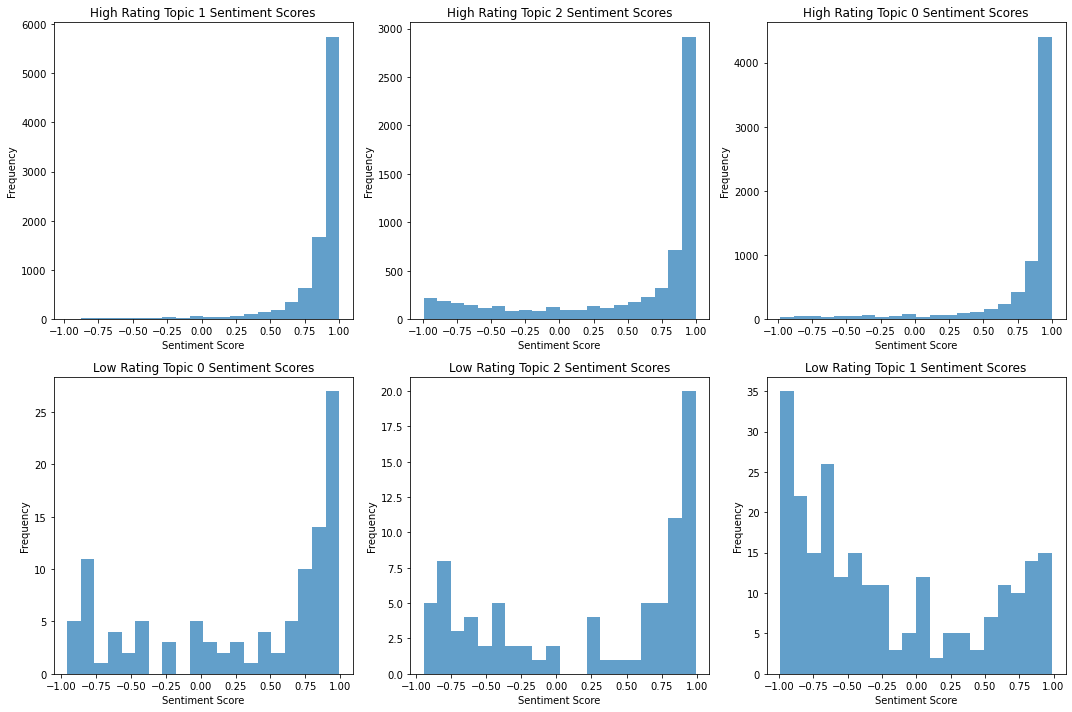

In [11]:
import numpy as np
import matplotlib.pyplot as plt

unique_high_topics = da['high_topic'].dropna().unique()
unique_low_topics = da['low_topic'].dropna().unique()

fig, ax = plt.subplots(2, max(len(unique_high_topics), len(unique_low_topics)), figsize=(15, 10))

if len(unique_high_topics) == 1:
    ax = np.array([[ax[0]], [ax[1]]])

for i, topic in enumerate(unique_high_topics):
    scores = da.loc[da['high_topic'] == topic, 'compound']
    ax[0, i].hist(scores, bins=20, alpha=0.7)
    ax[0, i].set_title(f'High Rating Topic {int(topic)} Sentiment Scores')
    ax[0, i].set_xlabel('Sentiment Score')
    ax[0, i].set_ylabel('Frequency')

for i, topic in enumerate(unique_low_topics):
    scores = da.loc[da['low_topic'] == topic, 'compound']
    ax[1, i].hist(scores, bins=20, alpha=0.7)
    ax[1, i].set_title(f'Low Rating Topic {int(topic)} Sentiment Scores')
    ax[1, i].set_xlabel('Sentiment Score')
    ax[1, i].set_ylabel('Frequency')

for i in range(len(unique_high_topics), ax.shape[1]):
    fig.delaxes(ax[0, i])
for i in range(len(unique_low_topics), ax.shape[1]):
    fig.delaxes(ax[1, i])

plt.tight_layout()
plt.show()
